In [1]:
import tensorflow

print(tensorflow.__version__)

2.6.0


실습에서 구현한 번역기는 글자 단위(Character-level)에서 구현된 번역기였습니다. 하지만 실제 번역기의 경우에는 글자 단위가 아니라 단어 단위(Word-level)에서 구현되는 것이 좀 더 보편적입니다.

동일한 데이터셋을 사용하면서 글자 단위와는 다른 전처리와 to_categorical() 함수가 아닌 임베딩 층(Embedding layer)를 추가하여 단어 단위의 번역기를 완성시켜보겠습니다. 하지만, 단어 단위로 할 경우에는 단어의 개수가 글자 단위로 했을 경우와 비교하여 단어장의 크기(Vocabulary) 크기도 커지고, 학습 속도도 좀 더 느려집니다. 학습과 테스트 시의 원활한 진행을 위해서 데이터에서 상위 33,000개의 샘플만 사용해주세요.

33000개 중 3000개는 테스트 데이터로 분리하여 모델을 학습한 후에 번역을 테스트 하는 용도로 사용합니다

## Step 1. 정제, 정규화, 전처리 (영어, 프랑스어 모두!)

글자 단위가 아닌 단어 단위의 번역기를 하기 위해서는 글자 단위에서는 신경쓰지 않았던 몇 가지 추가적인 전처리가 필요합니다.

#### 1. 구두점(Punctuation)을 단어와 분리해주세요.

일반적으로 영어권 언어의 경우에는 띄어쓰기 단위로 단어를 분리합니다. 토큰화(Tokenization) 라고도 불리는 이 작업은 어디서부터 어디까지가 하나의 단어인지를 구분하는 작업인데요, 그런데 띄어쓰기를 해주기 전에 구두점을 분리하는 작업이 필요할 때가 있습니다.
예를 들어서 'he is a good boy!'라는 문장이 있을 때, 이를 띄어쓰기 단위로 토큰화한다면 ['he', 'is', 'a', 'good', 'boy!']가 됩니다. 그런데 실제로 !는 boy와 붙어있는 한 단어가 아니므로 좀 더 올바른 전처리는 ['he', 'is', 'a', 'good', 'boy', '!']가 맞습니다.
!나 ? 또는 온점과 같은 특수문자들을 구두점(punctuation)이라고 부릅니다. 이들을 토큰화하기 전에 단어와 미리 분리시켜주세요!

분리 전 : he is a Good boy!

분리 후 : he is a Good boy !

#### 2. 소문자로 바꿔주세요.

기계가 보기에는 스펠링이 같더라도 대문자로 된 단어와 소문자로 된 단어는 서로 다른 단어입니다. 예를 들어 'Good'과 'good'은 기계가 보기에는 다른 단어입니다. 그래서 모든 문장에 대해서 전부 영어로 바꿔주는 작업을 하겠습니다.

변환 전 : he is a Good boy !

변환 후 : he is a good boy !

#### 3. 띄어쓰기 단위로 토큰화를 수행하세요.

띄어쓰기 단위로 토큰화를 수행해서 단어를 분리하는 작업을 해주세요. 기계는 이렇게 분리된 토큰들을 각각 하나의 단어로 인식할 수 있게 됩니다.

토큰화 전 : 'he is a good boy !'

토큰화 후 : ['he', 'is', 'a', 'good', 'boy', '!']

In [2]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

In [3]:
import os,sys,copy,time
import re

file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 197463


,eng,fra,cc
56046,He's strange sometimes.,Il est parfois bizarre.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
168770,I think it's time for me to call it quits.,Je pense qu'il est temps pour moi d'en rester là.,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
10762,I sure hope so.,Je l'espère vraiment.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
11598,Relax a moment.,Détendez-vous un instant !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
76247,"Where's your family, Tom?","Où est ta famille, Tom ?",CC-BY 2.0 (France) Attribution: tatoeba.org #2...


In [4]:
## 'cc'삭제 및 샘플데이터수 33000개로 한정 
lines = lines[['eng', 'fra']][:33000] # 3.3만개 샘플 사용
lines.sample(3)

,eng,fra
15826,The sea is blue.,La mer est bleue.
20362,Somebody saw you.,Quelqu'un vous a vus.
4906,I feel faint.,Je me sens mal.


#### 중복값 및 결측치처리 여부

-중복값은 나중에 단어빈도파악시 사용되므로, 제거하면 않되나,id 중복은 동일문장이 중복된것이므로. id중복은 파악및 제거필요

In [5]:
## id 중복치 파악및 제거 
print("lines.index.nunique()",lines.index.nunique())
if lines.index.nunique() < len(lines.index):
    pd.Index.drop_duplicates(lines,keep='first', inplace=True) 
    print("lines.index.nunique()",lines.index.nunique())    
    print("id 중복제거후 len(lines)",len(lines)) 
else:
    print("id 중복값없습니다.")
    

lines.index.nunique() 33000
id 중복값없습니다.


In [6]:
## 결측치제거 : 1개라도 있으면, 해당행 전체 제거

# encoder_input: eng
print("결측치 개수", lines['eng'].isnull().sum())
if lines['eng'].isnull().any().any():
    lines['eng'].dropna(how='any',inplace=True)
    print("결측치제거후 결측치 여부",lines['eng'].isnull().any().any())  
else:
    print("결측치없습니다.")
    
# decoder input, label:  fra 
print("결측치 개수",lines['fra'].isnull().sum())
if lines['fra'].isnull().any().any():
    lines['fra'].dropna(how='any',inplace=True)
    print("결측치제거후 결측치 여부",lines['fra'].isnull().any().any())
else:
    print("결측치없습니다.")

결측치 개수 0
결측치없습니다.
결측치 개수 0
결측치없습니다.


#### 1. 구두점(Punctuation)을 단어와 분리

In [7]:
# encoder input: eng
lines['eng'] = lines['eng'].apply(lambda x: re.sub(r"([!?.])", r" \1 ", x))
print(lines['eng'][:10],lines['eng'][-10:]) 

# decoder input, label:  fra
lines['fra'] = lines['fra'].apply(lambda x: re.sub(r"([!?.])", r" \1 ", x))
print(lines['fra'][:10],lines['fra'][-10:]) 


0     Go . 
1     Go . 
2     Go . 
3     Go . 
4     Hi . 
5     Hi . 
6    Run ! 
7    Run ! 
8    Run ! 
9    Run ! 
Name: eng, dtype: object 32990    Watch your fingers . 
32991    Watch your fingers . 
32992    Water is important . 
32993    We adopted a child . 
32994    We all cried a lot . 
32995    We all cried a lot . 
32996    We all felt hungry . 
32997    We also found this . 
32998    We are busy people . 
32999    We are watching TV . 
Name: eng, dtype: object
0                              Va  ! 
1                           Marche . 
2                        En route  ! 
3                           Bouge  ! 
4                           Salut  ! 
5                            Salut . 
6                           Cours  ! 
7                          Courez  ! 
8    Prenez vos jambes à vos cous  ! 
9                            File  ! 
Name: fra, dtype: object 32990                   Gare à vos doigts  ! 
32991                   Gare à tes doigts  ! 
32992                 L

#### 2. 소문자로 바꿔주세요

In [8]:
# encoder input: eng
lines['eng'] = lines['eng'].apply(lambda x: str(x).lower())
print(lines['eng'][:10],lines['eng'][-10:]) 

# decoder input, label:  fra
lines['fra'] = lines['fra'].apply(lambda x: str(x).lower())
print(lines['fra'][:10],lines['fra'][-10:]) 


0     go . 
1     go . 
2     go . 
3     go . 
4     hi . 
5     hi . 
6    run ! 
7    run ! 
8    run ! 
9    run ! 
Name: eng, dtype: object 32990    watch your fingers . 
32991    watch your fingers . 
32992    water is important . 
32993    we adopted a child . 
32994    we all cried a lot . 
32995    we all cried a lot . 
32996    we all felt hungry . 
32997    we also found this . 
32998    we are busy people . 
32999    we are watching tv . 
Name: eng, dtype: object
0                              va  ! 
1                           marche . 
2                        en route  ! 
3                           bouge  ! 
4                           salut  ! 
5                            salut . 
6                           cours  ! 
7                          courez  ! 
8    prenez vos jambes à vos cous  ! 
9                            file  ! 
Name: fra, dtype: object 32990                   gare à vos doigts  ! 
32991                   gare à tes doigts  ! 
32992                 l

#### 3. 띄어쓰기 단위로 토큰화수행

In [9]:
# encoder input: eng
lines['eng'] = lines['eng'].str.replace("\.{2,30}"," ") 
lines['eng'] = lines['eng'].str.replace(","," ") 
lines['eng'] = lines['eng'].str.replace("[' ']+"," ")
lines['eng'] = lines['eng'].str.split(' ')
print(lines['eng'][:10],lines['eng'][-10:])

# decoder input, label:  fra
lines['fra'] = lines['fra'].str.replace("\.{2,30}"," ") 
lines['fra'] = lines['fra'].str.replace(","," ") 
lines['fra'] = lines['fra'].str.replace("[' ']+"," ")
lines['fra'] = lines['fra'].str.split(' ')
print(lines['fra'][:10],lines['fra'][-10:])


/tmp/ipykernel_6569/3190069281.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  lines['eng'] = lines['eng'].str.replace("\.{2,30}"," ")
/tmp/ipykernel_6569/3190069281.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  lines['eng'] = lines['eng'].str.replace("[' ']+"," ")
/tmp/ipykernel_6569/3190069281.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  lines['fra'] = lines['fra'].str.replace("\.{2,30}"," ")


0     [go, ., ]
1     [go, ., ]
2     [go, ., ]
3     [go, ., ]
4     [hi, ., ]
5     [hi, ., ]
6    [run, !, ]
7    [run, !, ]
8    [run, !, ]
9    [run, !, ]
Name: eng, dtype: object 32990      [watch, your, fingers, ., ]
32991      [watch, your, fingers, ., ]
32992      [water, is, important, ., ]
32993     [we, adopted, a, child, ., ]
32994    [we, all, cried, a, lot, ., ]
32995    [we, all, cried, a, lot, ., ]
32996     [we, all, felt, hungry, ., ]
32997     [we, also, found, this, ., ]
32998     [we, are, busy, people, ., ]
32999     [we, are, watching, tv, ., ]
Name: eng, dtype: object
0                                   [va, !, ]
1                               [marche, ., ]
2                            [en, route, !, ]
3                                [bouge, !, ]
4                                [salut, !, ]
5                                [salut, ., ]
6                               [cours , !, ]
7                              [courez , !, ]
8    [prenez, vos, jambes, à, vo

/tmp/ipykernel_6569/3190069281.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  lines['fra'] = lines['fra'].str.replace("[' ']+"," ")


In [10]:
## 샘플데이터 변수명 지정
encoder_input = lines['eng']
decoder_input = lines['fra']
decoder_label = lines['fra']


### Step 2. 디코더의 문장에 시작 토큰과 종료 토큰을 넣어주세요.

글자 단위 번역기를 구현할 때와 마찬가지로 디코더의 입력 시퀀스 맨 앞에는 시작을 의미하는 토큰인 <sos>가 필요합니다. 그리고 교사 강요를 수행할 때, 디코더의 실제값이 되는 디코더의 레이블 시퀀스에는 종료를 의미하는 종료 토큰 <eos>가 필요합니다.
예를 들어 번역 문장이 "Courez!" 였다고 한다면, Step 1을 거친 후에는 다음과 같은 결과를 얻습니다.

Step 1을 수행한 후 : ['courez', '!']
    
이 문장에 대해서 각각 디코더의 입력 시퀀스와 레이블 시퀀스를 만들면 다음과 같습니다.

입력 시퀀스 : ['<sos>', 'courez', '!']
    
레이블 시퀀스 : ['courez', '!', '<eos>']
    
참고로 Step 2가 반드시 Step 1이 끝난 후에 이루어질 필요는 없습니다!
Step 1을 수행하는 중간에 수행해도 상관없습니다.

In [11]:
# 디코더 시작 토큰과 종료 토큰 추가
sos_token = '<SOS>'
eos_token = '<EOS>'
lines.fra = lines.fra.apply(lambda x : ['<SOS>'] + x + ['<EOS>'])
print('전체 샘플의 수 :',len(lines))
print("lines", lines[:5])

# decoder input, label
decoder_input1 = [[word for word in line if word != '<EOS>'] for line in decoder_input]
decoder_label1 = [[word for word in line if word != '<SOS>'] for line in decoder_label]
print("decoder_input1", decoder_input1[:5],decoder_label1[:5])


전체 샘플의 수 : 33000
lines          eng                             fra
0  [go, ., ]         [<SOS>, va, !, , <EOS>]
1  [go, ., ]     [<SOS>, marche, ., , <EOS>]
2  [go, ., ]  [<SOS>, en, route, !, , <EOS>]
3  [go, ., ]      [<SOS>, bouge, !, , <EOS>]
4  [hi, ., ]      [<SOS>, salut, !, , <EOS>]
decoder_input1 [['<SOS>', 'va', '!', ''], ['<SOS>', 'marche', '.', ''], ['<SOS>', 'en', 'route', '!', ''], ['<SOS>', 'bouge', '!', ''], ['<SOS>', 'salut', '!', '']] [['va', '!', '', '<EOS>'], ['marche', '.', '', '<EOS>'], ['en', 'route', '!', '', '<EOS>'], ['bouge', '!', '', '<EOS>'], ['salut', '!', '', '<EOS>']]


### Step 3. 케라스의 토크나이저로 텍스트를 숫자로 바꿔보세요.

딥러닝 모델은 텍스트가 아닌 숫자를 처리합니다. 케라스 토크나이저를 사용해서 각 단어를 고유한 정수로 바꿔보세요.
케라스 토크나이저의 사용법은 아래의 링크에서 2. 케라스(Keras)의 텍스트 전처리에 설명되어 있습니다.

위키독스: https://wikidocs.net/31766

위 링크의 가이드를 통해서 영어와 프랑스어에 대한 토크나이저를 각각 생성하고, tokenizer.texts_to_sequences()를 사용하여 모든 샘플에 대해서 정수 시퀀스로 변환해보세요.

##### 참고: tokenizer인자들
tf.keras.preprocessing.text.Tokenizer(
    num_words=None,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    char_level=False,
    oov_token=None,
    analyzer=None,
    **kwargs
)

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer

#### 영어 Tokenize

In [13]:
## 영어 
# fit_on_texts()안에 코퍼스를 입력으로 하면 빈도수를 기준으로 단어 집합을 생성.
# Tokening
tokenizer =  Tokenizer() #oov_token = 'OOV') 
tokenizer.fit_on_texts(lines['eng']) 
word2index_eng = tokenizer.word_index
index2word_eng = {x[1]: x[0] for x in word2index_eng.items()}
print("OOV처리후전체단어집합크기:", len(word2index_eng)) 
#Tokenizer는 pad용 0번인덱스는 놔두고 넘버링됨, oov은 인덱스1로추가됨,나머지인덱스는 빈도순

print("word2index_eng[:10] \n", len(word2index_eng), list(word2index_eng)[:10])
print("index2word_eng[:10] \n", len(index2word_eng), list(index2word_eng)[:10])
print("word_counts_eng[:10] \n", len(tokenizer.word_counts), list(tokenizer.word_counts)[:10])

# 영어 정수인코딩
input_text = tokenizer.texts_to_sequences(lines['eng'])
print("영어 정수인코딩:", len(input_text), input_text[:10])

OOV처리후전체단어집합크기: 4713
word2index_eng[:10] 
 4713 ['', '.', 'i', 'you', '?', 'tom', 'it', 'is', 's', 'a']
index2word_eng[:10] 
 4713 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
word_counts_eng[:10] 
 4713 ['go', '.', '', 'hi', 'run', '!', 'who', '?', 'wow', 'duck']
영어 정수인코딩: 33000 [[29, 2, 1], [29, 2, 1], [29, 2, 1], [29, 2, 1], [762, 2, 1], [762, 2, 1], [197, 24, 1], [197, 24, 1], [197, 24, 1], [197, 24, 1]]


#### 프랑스어 Tokenize

In [14]:
## 프랑스어: 
# fit_on_texts()안에 코퍼스를 입력으로 하면 빈도수를 기준으로 단어 집합을 생성.
tokenizer =  Tokenizer() #oov_token = 'OOV') 
tokenizer.fit_on_texts(lines['fra']) 
word2index_fra = tokenizer.word_index
index2word_fra = {x[1]: x[0] for x in word2index_fra.items()}
print("OOV처리후전체단어집합크기:", len(word2index_fra)) #pad용1개자동처리?,oov1개더해짐
#Tokenizer는 pad용 0번인덱스는 놔두고 넘버링됨, oov은 인덱스1로추가됨,나머지인덱스는 빈도순

print("word2index_fra[:10] \n", len(word2index_fra), list(word2index_fra)[:10])
print("index2word_fra[:10] \n", len(index2word_fra), list(index2word_fra)[:10])
print("word_counts_fra[:10] \n", len(tokenizer.word_counts), list(tokenizer.word_counts)[:10])

# 프랑스어 정수인코딩
target_text = tokenizer.texts_to_sequences(lines['fra'])
print("프랑스어 정수인코딩:",target_text[:10])

OOV처리후전체단어집합크기: 10308
word2index_fra[:10] 
 10308 ['<sos>', '<eos>', '', '.', 'je', 'est', '?', 'tom', '!', 'pas']
index2word_fra[:10] 
 10308 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
word_counts_fra[:10] 
 10308 ['<sos>', 'va', '!', '', '<eos>', 'marche', '.', 'en', 'route', 'bouge']
프랑스어 정수인코딩: [[1, 74, 9, 3, 2], [1, 343, 4, 3, 2], [1, 25, 479, 9, 3, 2], [1, 703, 9, 3, 2], [1, 744, 9, 3, 2], [1, 744, 4, 3, 2], [1, 3642, 9, 3, 2], [1, 3643, 9, 3, 2], [1, 178, 241, 968, 26, 241, 2790, 9, 3, 2], [1, 1440, 9, 3, 2]]


In [15]:
## 단어장의 크기 
eng_vocab_size = len(word2index_eng) +1
fra_vocab_size = len(word2index_fra) +1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 4714
프랑스어 단어장의 크기 : 10309


In [16]:
## max_length
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 9
프랑스어 시퀀스의 최대 길이 17


In [17]:
## 필요 통계치 현황
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 33000
영어 단어장의 크기 : 4714
프랑스어 단어장의 크기 : 10309
영어 시퀀스의 최대 길이 9
프랑스어 시퀀스의 최대 길이 17


### Step 4. 임베딩 층(Embedding layer) 사용하기

이번에는 입력이 되는 각 단어를 임베딩 층을 사용하여 벡터화하겠습니다.
임베딩 층을 사용하는 방법과 그 설명에 대해서는 아래의 링크의 1. 케라스 임베딩 층(Keras Embedding layer) 을 참고하세요.

위키독스:https://wikidocs.net/33793

실제 번역기 구현을 위해서 사용할 수 있는 인코더 코드의 예시는 다음과 같습니다. 이를 통해서 인코더와 디코더의 임베딩 층을 각각 구현해보세요.

from tensorflow.keras.layers import Input, Embedding, Masking

인코더에서 사용할 임베딩 층 사용 예시

encoder_inputs = Input(shape=(None,))

enc_emb =  Embedding(단어장의 크기, 임베딩 벡터의 차원)(encoder_inputs)

encoder_lstm = LSTM(hidden state의 크기, return_state=True)

encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

주의할 점은 인코더와 디코더의 임베딩 층은 서로 다른 임베딩 층을 사용해야 하지만, 디코더의 훈련 과정과 테스트 과정(예측 과정)에서의 임베딩 층은 동일해야 한다는 것입니다!

#### Input, target data  분리

In [18]:
## encoder input
encoder_input = input_text

## decoder input, decoder input 분리
# EOS(종료토큰) 제거하고 decoder_input 만들기
decoder_input = [[word for word in line if word != word2index_fra['<eos>']] for line in target_text] 
# SOS(시작토큰) 제거하고 decoder_target 만들기
decoder_target = [[word for word in line if word != word2index_fra['<sos>'] ] for line in target_text]

print("encoder_input",len(encoder_input ), encoder_input[:5])
print("decoder_input",len(decoder_input ), decoder_input[:5])
print("decoder_target",len(decoder_target ), decoder_target[:5])


encoder_input 33000 [[29, 2, 1], [29, 2, 1], [29, 2, 1], [29, 2, 1], [762, 2, 1]]
decoder_input 33000 [[1, 74, 9, 3], [1, 343, 4, 3], [1, 25, 479, 9, 3], [1, 703, 9, 3], [1, 744, 9, 3]]
decoder_target 33000 [[74, 9, 3, 2], [343, 4, 3, 2], [25, 479, 9, 3, 2], [703, 9, 3, 2], [744, 9, 3, 2]]


#### padding 처리

padding 인자

tf.keras.preprocessing.sequence.pad_sequences(
    sequences,
    maxlen=None,
    dtype='int32',
    padding='pre',
    truncating='pre',
    value=0.0
) # value= 0.0은,tf.keras의 tokenizer에서,내부 코드로 미리 0번 인덱스를 마련해놓아서, default인 0.0 으로 그냥 놔두어도 됨 

In [19]:
from tensorflow.keras.layers import Input, Embedding, Masking,BatchNormalization,Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [20]:
## padding 처리

# encoder : 영어
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')

# decoder : 프랑스어
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')

print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('영어패딩 결과3개 :',encoder_input[:3] )
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 입력패딩 결과3개 :',decoder_input[:3] )
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))
print('프랑스어 출력패딩결과3개 :',decoder_target[:3] )


영어 데이터의 크기(shape) : (33000, 9)
영어패딩 결과3개 : [[29  2  1  0  0  0  0  0  0]
 [29  2  1  0  0  0  0  0  0]
 [29  2  1  0  0  0  0  0  0]]
프랑스어 입력데이터의 크기(shape) : (33000, 17)
프랑스어 입력패딩 결과3개 : [[  1  74   9   3   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1 343   4   3   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1  25 479   9   3   0   0   0   0   0   0   0   0   0   0   0   0]]
프랑스어 출력데이터의 크기(shape) : (33000, 17)
프랑스어 출력패딩결과3개 : [[ 74   9   3   2   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [343   4   3   2   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 25 479   9   3   2   0   0   0   0   0   0   0   0   0   0   0   0]]


In [21]:
## train, test data 분리
# test data 개수
n_of_test = 3000

# permutation
indices_permutation = np.random.permutation(len(encoder_input))
#indices_permutation = np.arange(len(encoder_input))
shuffled_encoder_input = encoder_input[indices_permutation]
shuffled_decoder_input = decoder_input[indices_permutation]
shuffled_decoder_target = decoder_target[indices_permutation]

# train, test data
encoder_input_train = shuffled_encoder_input[:-n_of_test]
decoder_input_train = shuffled_decoder_input[:-n_of_test]
decoder_target_train = shuffled_decoder_target[:-n_of_test]

encoder_input_test = shuffled_encoder_input[-n_of_test:]
decoder_input_test = shuffled_decoder_input[-n_of_test:]
decoder_target_test = shuffled_decoder_target[-n_of_test:]

print('영어 Train input data 크기(shape) :',np.shape(encoder_input_train))
print('프랑스어 Train input data 크기(shape) :',np.shape(decoder_input_train))
print('프랑스어 Train target data 크기(shape) :',np.shape(decoder_target_train))

print('영어 Test input data 크기(shape) :',np.shape(encoder_input_test))
print('프랑스어 Test input data 크기(shape) :',np.shape(decoder_input_test))
print('프랑스어 Test target data 크기(shape) :',np.shape(decoder_target_test))

영어 Train input data 크기(shape) : (30000, 9)
프랑스어 Train input data 크기(shape) : (30000, 17)
프랑스어 Train target data 크기(shape) : (30000, 17)
영어 Test input data 크기(shape) : (3000, 9)
프랑스어 Test input data 크기(shape) : (3000, 17)
프랑스어 Test target data 크기(shape) : (3000, 17)


In [22]:
## embedding layer설정

#1. encoder embedding layer: 영어 embedding layer
enbedding_dim = 256
enc_emb = Embedding(eng_vocab_size, enbedding_dim)

#2. decoder embedding layer: 프랑스어 embedding layer
enbedding_dim = 256
dec_emb = Embedding(fra_vocab_size, enbedding_dim)

### Step 5. 모델 구현하기
단어 단위 번역기의 모델을 완성시켜보세요! 이때는 label이 integer 값이므로 categorical entropy loss가 아닌 sparse categorical entropy loss를 사용

In [23]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model

#### 모델 구현

In [24]:
# Hyper params
eng_vocab_size = eng_vocab_size
fra_vocab_size = fra_vocab_size
enbedding_dim = 256
hidden_size1 = 256
dropout_rate = 0.3
learning_rate = 0.001
batch_size= 256
epochs= 25

In [25]:
# 인코더
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(eng_vocab_size, enbedding_dim)(encoder_inputs)
#enc_masking = Masking(mask_value=0.0)(enc_emb) # 패딩 0은 연산에서 제외
enc_bn = BatchNormalization()(enc_emb)
enc_do = Dropout(dropout_rate)(enc_bn)
encoder_lstm = LSTM(hidden_size1, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_do) 
encoder_states = [state_h, state_c]

# 디코더
decoder_inputs = Input(shape=(None,))
dec_emb = Embedding(fra_vocab_size, enbedding_dim)(decoder_inputs)
#dec_masking = Masking(mask_value=0.0)(dec_emb) # 패딩 0은 연산에서 제외
dec_bn = BatchNormalization()(dec_emb)
dec_do = Dropout(dropout_rate)(dec_bn)
decoder_lstm = LSTM(hidden_size1, return_sequences = True, return_state=True)
# decoder_outputs는 모든 time step의 hidden state
decoder_outputs, _, _= decoder_lstm(dec_do ,initial_state = encoder_states)
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

# model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
rmsprop = tensorflow.keras.optimizers.RMSprop(learning_rate=learning_rate)
model.compile(optimizer=rmsprop, loss="sparse_categorical_crossentropy", metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 256)    1206784     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 256)    2639104     input_2[0][0]                    
______________________________________________________________________________________________

In [26]:
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=batch_size, epochs=epochs)


Epoch 1/25
118/118 [==============================] - 12s 61ms/step - loss: 1.8985 - acc: 0.7538 - val_loss: 3.3013 - val_acc: 0.6024
Epoch 2/25
118/118 [==============================] - 7s 56ms/step - loss: 1.1028 - acc: 0.8286 - val_loss: 2.0802 - val_acc: 0.6743
Epoch 3/25
118/118 [==============================] - 7s 56ms/step - loss: 0.9111 - acc: 0.8503 - val_loss: 1.6797 - val_acc: 0.6905
Epoch 4/25
118/118 [==============================] - 7s 56ms/step - loss: 0.7956 - acc: 0.8642 - val_loss: 1.0420 - val_acc: 0.8035
Epoch 5/25
118/118 [==============================] - 7s 56ms/step - loss: 0.7097 - acc: 0.8748 - val_loss: 0.8015 - val_acc: 0.8684
Epoch 6/25
118/118 [==============================] - 7s 56ms/step - loss: 0.6401 - acc: 0.8840 - val_loss: 0.7333 - val_acc: 0.8766
Epoch 7/25
118/118 [==============================] - 7s 57ms/step - loss: 0.5831 - acc: 0.8918 - val_loss: 0.6965 - val_acc: 0.8833
Epoch 8/25
118/118 [==============================] - 7s 57ms/step -

#### 학습결과: 학습도 잘되고, Overfitting도 별로 없는 양호한 결과였슴

loss: 0.2263
    
val_loss: 0.5665
    
Accuracy: 94.87%
    
val_Accuracy: 90.28%    


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


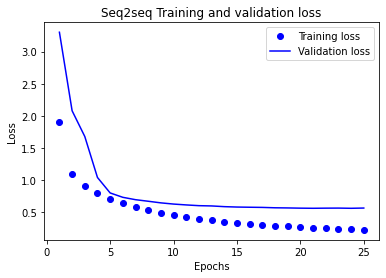

In [28]:
import matplotlib.pyplot as plt

## Loss
history1 = history.history
print(history1.keys()) 

loss = history1['loss']
val_loss = history1['val_loss']
epochs = range(1, len(loss) + 1)

# LOSS
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Seq2seq Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

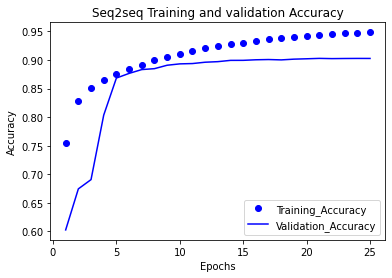

In [29]:
## Accuracy
history1 = history.history
acc = history1['acc']
val_acc = history1['val_acc']
epochs = range(1, len(acc) + 1)

# Accuracy
plt.plot(epochs, acc, 'bo', label='Training_Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation_Accuracy')
plt.title('Seq2seq Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Step 6. 모델 평가하기

단어 단위 번역기를 이용하여 훈련 데이터의 샘플과 테스트 데이터의 샘플로 번역 문장을 만들어보고 정답 문장과 번역 문장을 비교해보세요. 이전 스텝들에서 우리가 공부했던 모델의 경우 글자 단위에서 구현된 번역기이며 현재 프로젝트를 진행할 때 사용하는 모델은 단어 단위에서 구현되는 번역기입니다.

#### (1) 테스트 모드의 인코더 만들기

In [30]:
## 테스트 모드의 인코더 만들기

encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 256)         1206784   
_________________________________________________________________
batch_normalization (BatchNo (None, None, 256)         1024      
_________________________________________________________________
dropout (Dropout)            (None, None, 256)         0         
_________________________________________________________________
lstm (LSTM)                  [(None, 256), (None, 256) 525312    
Total params: 1,733,120
Trainable params: 1,732,608
Non-trainable params: 512
_________________________________________________________________


#### (2) 테스트모드의 디코더 설계

In [31]:
## 테스트모드의 디코더 설계

# 이전 time step의 hidden state를 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size1,))
# 이전 time step의 cell state를 저장하는 텐서
decoder_state_input_c = Input(shape=(hidden_size1,))
# 이전 time step의 hidden state와 cell state를 하나의 변수에 저장
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# decoder_states_inputs를 현재 time step의 초기 상태로 사용.
# 구체적인 동작 자체는 def decode_sequence()에 구현.

# decoder_lstm()안에는 decoder_input 대신에 기 학습된 모델의 
#==> 직전 layer인 dropout layer로 연결시켰습니다
decoder_outputs, state_h, state_c = decoder_lstm(model.layers[7].output, initial_state = decoder_states_inputs)
# 현재 time step의 hidden state와 cell state를 하나의 변수에 저장.
decoder_states = [state_h, state_c]


#### (3) 테스트모드의 디코더 출력층 재설계

In [32]:
## 테스트모드의 디코더 출력층 재설계
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 256)    2639104     input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, 256)    1024        embedding_3[0][0]                
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, None, 256)    0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [33]:
## 기존 사전 사용활용
word2index_eng = word2index_eng
index2word_eng = index2word_eng
word2index_fra = word2index_fra
index2word_fra = index2word_fra


#### (4) 테스트 모드의 예측함수 만들기

In [34]:
## 테스트 모드의 예측함수 만들기

def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # 에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1,1)) 
    target_seq[0, 0] = word2index_fra['<sos>']
    
    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index2word_fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # 에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '<eos>' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장     
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

#### (5) 테스트 모드의 5개단어 출력결과

In [35]:
## 테스트 모드의 5개단어 출력결과

for seq_index in [3,50,100,300,1001]: # 입력 문장의 인덱스 (자유롭게 선택해 보세요)
    input_seq = encoder_input[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.eng[seq_index])
    print('정답 문장:', lines.fra[seq_index][1:len(lines.fra[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1]) # '\n'을 빼고 출력

-----------------------------------
입력 문장: ['go', '.', '']
정답 문장: ['bouge', '!', '']
번역기가 번역한 문장:  va !  <eos
-----------------------------------
입력 문장: ['hello', '!', '']
정답 문장: ['bonjour', '!', '']
번역기가 번역한 문장:  salut !  <eos
-----------------------------------
입력 문장: ['got', 'it', '?', '']
정답 문장: ['t', 'as', 'capté\u202f', '?', '']
번역기가 번역한 문장:  est-ce ?  <eos
-----------------------------------
입력 문장: ['hang', 'on', '.', '']
정답 문장: ['tiens', 'bon', '!', '']
번역기가 번역한 문장:  tiens bon !  <eos
-----------------------------------
입력 문장: ['here', 's', '$5', '.', '']
정답 문장: ['voilà', 'cinq', 'dollars', '.', '']
번역기가 번역한 문장:  voilà cinq ici .


#### (6) 출력결과 Naver 사전해석과 비교

#### (7) 번역기 해석결과 요약

-5개 단어 모두 정답과딱맞아 떨어지지는 않았으나, 
 한국어해석으로는 거의 같은 뜻으로 해석되었습니다.

-작은 모델임을 감안했을때 결과가 훌륭한 편입니다.    


## 회고

본 프로젝트는 자연어처리 모델인 seq2seq 모델로서, 단어단위로 구현된 번역기를 만들어보는 프로젝트였습니다.
프랑스어와 영어의 병렬 코퍼스인 fra-eng.zip을 다운받아 사용하였는데, 
33000개 중 3000개는 테스트 데이터로 분리하여 모델을 학습한 후에 번역을 테스트 하는
용도로 사용하였습니다. 

#### Step 1. 정제, 정규화, 전처리 (영어, 프랑스어 모두!)

먼저 1단계에서는 33000개의 문장들을 tokenize하기 편하게, 전처리하기위해서,
id 상 중복된 문장들을 제거하기 위해, id상 중복된 문장들을 파악했으나, 없었습니다.
그리고, 결측치제거하려고, 결측치파악을 하였으나, 역시 없었습니다.
그 다음 데이터 정제를 위해서, 구두점 분리, 소문자로 변경작업, 전체 문장을
단어(토큰)별 띄어쓰기 리스트로 만들어서, 기계가 처리하기 깔끔하게 처리했습니다. 

#### Step 2. 디코더의 문장에 시작 토큰과 종료 토큰을 추가

상기에서 깔끔하게 단어별 리스트로 정제된 문장들중 디코더에서 처리할 프랑스어 문장에대해,
문장맨앞에 <SOS> , 맨뒤에 <EOS> 토큰을 입력하였습니다. 

#### Step 3. 케라스의 토크나이저로 텍스트를 숫자로 변환.

Keras의 Tokenizer를 사용해서,전체 문장의 각 단어들을 고유한 정수로 처리합니다 
먼저 영어입니다. 영어 Tokenizer를 생성하고서,tokenizer.fit_on_texts(lines['eng'])로
영어를 출현빈도순으로 토큰화한후,4713개의 단어가 등록된 word2index_eng, 
index2word_eng 사전을 만들었습니다.
그리고,tokenizer.texts_to_sequences()를 사용하여 모든 샘플에 대해서 정수 시퀀스로
변환했습니다.

다음의 프랑스어도 동일한 과정을 거쳐서, 10308개의 단어가 등록된 word2index_fra,
index2word_fra 사전을 만들었습니다.
그리고,tokenizer.texts_to_sequences()를 사용하여 모든 샘플에 대해서 정수 시퀀스로
변환했습니다.

Tokenizer에는 나중에 처리할 padding용 0번인덱스는 놔두고, 1부터의 고유한 정수인덱스로 
넘버링하는 기능이 있습니다.
단어장의 크기는 padding용 0번을 포함하여 계산하였습니다. 
영어 단어장인 eng_vocab_size 는 len(word2index_eng) +1 하여 4714개,
프랑스어 단어장인 fra_vocab_size 는 len(word2index_fra) +1하여 10309개입니다.
그리고 padding시에 활용할 한문장의 최대길이(max_len)는 영어가 9개, 프랑스어가 17개입니다.

#### Step 4. 임베딩 층(Embedding layer) 사용하기

이번에는 전단계에서, 단어별로 토크화한 문장들을 임베딩 층을 사용하여
벡터화해보겠습니다.
이때 인코더와 디코더의 임베딩 층은 서로 다른 임베딩 층을 사용해야 하지만,
디코더의 훈련 과정과 테스트 과정(예측 과정)에서의 임베딩 층은 동일해야 한다는 점을 
주의해서, 작업했습니다.

이 단계에서, 데이터를 encoder_input,decoder_input,decoder_target을 분리하고서,
decoder input에는 시작을 의미하는 <SOS>만 남기고,<EOS>는 제거하였으며,
teacher forcing의 수행에 쓰이는 decoder target은 종료를 의미하는 <EOS>만 남기고, 
<SOS>는 제거하였습니다.

디음은 pad_sequences()메서드로 영어, 프랑스어 모두 Padding처리하였습니다. 
영어는 최대길이 9개단어로 한문장의 길이를 동일하게 Padding하고, 프랑스어는 17개를 최대길이로 
Padding 처리하였습니다.

이렇게 준비가 완료된 데이터들을 train, test data 로 분리하였습니다.
test data 개수는 33000개중 3000개로 하였고, 데이터의 고른 분포를 위해서,
분리전에 미리 permutation해서,고르게 분포시켰습니다. 

그리고서,다음 단계인 모델구현에서 사용될 언어별 Embedding layer을 준비하였습니다.
encoder embedding layer: 영어 embedding layer
enc_emb = Embedding(eng_vocab_size, enbedding_dim)

decoder embedding layer: 프랑스어 embedding layer
dec_emb = Embedding(fra_vocab_size, enbedding_dim)


#### Step 5. 모델 구현

모델 구현에는 인코더와 디코더로 크게 나뉘고, 각각 임베딩층, 배치노말, 드롭아웃,
LSTM레이어를 기본으로 배치했습니다.  배치모말레이어는 배치단위로 정규화를해서, 학습이 잘되도록하고, 
드롭아웃레이어는 과대적합을 피하기 위해서였습니다.

하이퍼파람은 
eng_vocab_size = 4714
fra_vocab_size = 10309
enbedding_dim = 256
hidden_size1 = 256
dropout_rate = 0.3
learning_rate = 0.001
batch_size= 256
epochs= 25
로 설정하였습니다.

인코더는
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(eng_vocab_size, enbedding_dim)(encoder_inputs)
enc_bn = BatchNormalization()(enc_emb)
enc_do = Dropout(dropout_rate)(enc_bn)
encoder_lstm = LSTM(hidden_size1, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_do) 
encoder_states = [state_h, state_c]
​
디코더는
decoder_inputs = Input(shape=(None,))
dec_emb = Embedding(fra_vocab_size, enbedding_dim)(decoder_inputs)
dec_bn = BatchNormalization()(dec_emb)
dec_do = Dropout(dropout_rate)(dec_bn)
decoder_lstm = LSTM(hidden_size1, return_sequences = True, return_state=True)
decoder_outputs, _, _= decoder_lstm(dec_do ,initial_state = encoder_states)
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)
로 하여서,
인코더와는 다르게,return_sequences = True, return_state=True로 놓아서,
decoder_outputs이 다음 time step의 input,hidden state로 들어가게 하였습니다.   

옵티마이저는 tensorflow.keras.optimizers.RMSprop()를 직접써서, 학습율을 0.001로 설정
하였고, 손실함수는 정수형 벡터라서,sparse_categorical_crossentropy를 사용하였습니다. 

학습은 처음에 epoch 100회로 하였는데, 25회부터 과대적합이 발생되어서,커널 restart후
25회로 재 학습하였습니다.
학습결과는 학습도 잘되고, Overfitting도 별로 없는 양호한 결과였습니다.
loss: 0.2263, val_loss: 0.5665, Accuracy: 94.87%, val_Accuracy: 90.28%

학습과정상의 loss, val_loss의 과정과 Accuracy,val_accuracy를 시각화해서
val_loss가 우하향하고, val_accccuracy가 우상향하는 모습을 보았습니다.


#### Step 6. 모델 평가하기

테스트 모드의 인코더 만들기는 기존의 모델을 그대로 사용하였습니다
그런데, 디코더모델은 teacher forcing이 아닌, 직전 timetep의 out을 그대로 입력으로 받도록
재설계하였고, decoder_lstm()안에는 decoder_input 대신에 기 학습된 모델의 
직전 layer인 dropout layer로 연결시켰습니다

그리고, 테스트모드에서의 인코더와 재설계된 디코드를 이용하여,
입력단어(영어)를 받아서, 예측단어(프랑스어로 번역단어)를 출력하는
decode_sequence()함수를 만들었습니다.

이 함수에 5개단어 출력결과를, Naver사전에서도 재확인해보았습니다(입력단어별 맨우측기재)

###### 1. 입력 문장: ['go', '.', ''],     네이버영어사전 해석: 가다
    
정답 문장: ['bouge', '!', ''],     네이버프랑스어사전 해석: 움직이다, 이동하다
    
번역기가 번역한 문장:  va !  <eos, 네이버프랑스어사전 해석: 가다
​
###### 2.입력 문장: ['hello', '!', ''],   네이버영어사전 해석:  안녕하세요
                          
정답 문장: ['bonjour', '!', ''],   네이버프랑스어사전 해석: 안녕하세요
                          
번역기가 번역한 문장:   salut !  <eos , 네이버프랑스어사전 해석: 안녕하세요, 구원             
        
###### 3. 입력 문장: ['got', 'it', '?', ''],           네이버영어사전 해석: 알겠어요?
    
정답 문장: ['t', 'as', 'capté\u202f', '?', ''], 네이버프랑스어사전 해석: 잡았어?
    
번역기가 번역한 문장:  est-ce que ça a , 네이버프랑스어사전 해석: 이게무슨의미있는일인가다
        
###### 4.입력 문장: ['hang', 'on', '.', ''],   네이버영어사전 해석: 기다려
    
정답 문장: ['tiens', 'bon', '!', ''],   네이버프랑스어사전 해석: 가만있어
    
번역기가 번역한 문장:  attendez un peu, 네이버프랑스어사전 해석: 잠깐만
    
    
###### 5.입력 문장: ['here', 's', '$5', '.', ''],        네이버영어사전 해석:여기 5달러 있다 

정답 문장: ['voilà', 'cinq', 'dollars', '.', ''], 네이버프랑스어사전 해석:여기 5달러 있다

번역기가 번역한 문장:  voilà cinq ici ,           네이버프랑스어사전 해석: 여기 5개가 있다.       
        
​
5개단어 번역기 해석결과는 5개 단어 모두 정답과딱맞아 떨어지지는 않았으나, 
한국어해석으로는 거의 같은 뜻으로 해석되었습니다.
작은 모델임을 감안했을때 결과가 훌륭한 편입니다

본 프로젝트를 통하여, 자연어처리모델인 seq2seq모델을 처음부터 끝까지 만들어 본 좋은
기회였습니다.
좀 더 큰 모델로 좀 더 기간을 투입하면, 꽤 훌륭한 모델을 만들수 있을 것 같은 자신감이 
생겼습니다. 감사합니다.


In [ ]:
루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

평가문항	상세기준
1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다.

구두점, 대소문자, 띄어쓰기 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.
2. seq2seq 기반의 번역기 모델이 정상적으로 구동된다.

seq2seq 모델 훈련결과를 그래프로 출력해보고, validation loss그래프가 우하향하는 경향성을 보이며 학습이 진행됨이 확인되었다.
3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.

테스트용 디코더 모델이 정상적으로 만들어졌으며, input(영어)와 output(프랑스어) 모두 한글로 번역해서 결과를 출력해보았고, 둘의 내용이 유사함을 확인하였다.